# Module import

In [1]:
!pip install torch==2.0.0 torchvision==0.15.1
!pip install d2l==1.0.3

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 619.9/619.9 MB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.0/21.0 MB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 849.3/849.3 kB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 557.1/557.1 MB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.1/317.1 MB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 168.4/168.4 MB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.6/54.6 MB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.6/102.6 MB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 173.2/173.2 MB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 177.1/177.1 MB 3.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━

In [2]:
import warnings
import torch
import torchvision
from torchvision.utils import save_image
from torchvision.io import read_image
from torch.utils.data import Dataset, Subset
from torchvision import datasets
from torchvision.transforms import ToTensor
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as tf
from torch.utils.data import DataLoader
from torch import nn
from d2l import torch as d2l

import matplotlib.pyplot as plt
from glob import glob
import os
import pandas as pd
import numpy as np
import cv2


#Import data

In [3]:
d2l.DATA_HUB['pokemon'] = (d2l.DATA_URL + 'pokemon.zip',
                           'c065c0e2593b8b161a2d7873e42418bf6a21106c')

data_dir = d2l.download_extract('pokemon')
pokemon = torchvision.datasets.ImageFolder(data_dir)

In [4]:
batch_size = 256
transformer = torchvision.transforms.Compose([
    torchvision.transforms.Resize((64, 64)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(0.5, 0.5)
])
pokemon.transform = transformer
data_iter = torch.utils.data.DataLoader(
    pokemon, batch_size=batch_size,
    shuffle=True, num_workers=d2l.get_dataloader_workers())

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


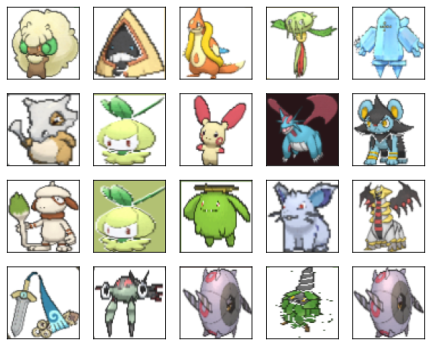

In [5]:
warnings.filterwarnings('ignore')
d2l.set_figsize((4, 4))
for X, y in data_iter:
    imgs = X[:20,:,:,:].permute(0, 2, 3, 1)/2+0.5
    d2l.show_images(imgs, num_rows=4, num_cols=5)
    break

##Pretrain the GAN model

### Generator

In [6]:
class G_block(nn.Module):
    def __init__(self, out_channels, in_channels=3, kernel_size=4, strides=2,
                 padding=1, **kwargs):
        super(G_block, self).__init__(**kwargs)
        self.conv2d_trans = nn.ConvTranspose2d(in_channels, out_channels,
                                kernel_size, strides, padding, bias=False)
        self.batch_norm = nn.BatchNorm2d(out_channels)
        self.activation = nn.ReLU()

    def forward(self, X):
        return self.activation(self.batch_norm(self.conv2d_trans(X)))

In [48]:
def get_fresh_net_G():

    n_G = 64
    net_G = nn.Sequential(
        G_block(in_channels=100, out_channels=n_G*8,
                strides=1, padding=0),                  # Output: (64 * 8, 4, 4)
        G_block(in_channels=n_G*8, out_channels=n_G*4), # Output: (64 * 4, 8, 8)
        G_block(in_channels=n_G*4, out_channels=n_G*2), # Output: (64 * 2, 16, 16)
        G_block(in_channels=n_G*2, out_channels=n_G),   # Output: (64, 32, 32)
        nn.ConvTranspose2d(in_channels=n_G, out_channels=3,
                        kernel_size=4, stride=2, padding=1, bias=False),
        nn.Tanh())  # Output: (3, 64, 64)
    return net_G

### Discriminator

In [8]:
class D_block(nn.Module):
    def __init__(self, out_channels, in_channels=3, kernel_size=4, strides=2,
                padding=1, alpha=0.2, **kwargs):
        super(D_block, self).__init__(**kwargs)
        self.conv2d = nn.Conv2d(in_channels, out_channels, kernel_size,
                                strides, padding, bias=False)
        self.batch_norm = nn.BatchNorm2d(out_channels)
        self.activation = nn.LeakyReLU(alpha, inplace=True)

    def forward(self, X):
        return self.activation(self.batch_norm(self.conv2d(X)))

In [43]:
def get_fresh_net_D():

    n_D = 64
    net_D = nn.Sequential(
        D_block(n_D),  # Output: (64, 32, 32)
        D_block(in_channels=n_D, out_channels=n_D*2),  # Output: (64 * 2, 16, 16)
        D_block(in_channels=n_D*2, out_channels=n_D*4),  # Output: (64 * 4, 8, 8)
        D_block(in_channels=n_D*4, out_channels=n_D*8),  # Output: (64 * 8, 4, 4)
        nn.Conv2d(in_channels=n_D*8, out_channels=1,
              kernel_size=4, bias=False))  # Output: (1, 1, 1)
    return net_D

### Train

In [10]:
def update_D(X, Z, net_D, net_G, loss, trainer_D):
    """Update discriminator.


    Defined in :numref:`sec_basic_gan`"""
    batch_size = X.shape[0]
    ones = torch.ones((batch_size,), device=X.device)
    zeros = torch.zeros((batch_size,), device=X.device)
    trainer_D.zero_grad()
    real_Y = net_D(X)
    fake_X = net_G(Z)
    # Do not need to compute gradient for `net_G`, detach it from
    # computing gradients.
    fake_Y = net_D(fake_X.detach())
    loss_D = (loss(real_Y, ones.reshape(real_Y.shape)) +
              loss(fake_Y, zeros.reshape(fake_Y.shape))) / 2


    loss_D.backward()
    trainer_D.step()


    return loss_D

In [53]:
def train(net_D, net_G, data_iter, num_epochs, lr, latent_dim,
          device=d2l.try_gpu(), pretrained_D=None, freeze_D=False, pretrained_G=None):
    loss = nn.BCEWithLogitsLoss(reduction='sum')

    if pretrained_D is not None:
        # Load pretrained weights into the Discriminator
        net_D.load_state_dict(torch.load(pretrained_D))
    else:
        for w in net_D.parameters():
            nn.init.normal_(w, 0, 0.02)
    if pretrained_G is not None:
        net_G.load_state_dict(torch.load(pretrained_G))
    else:
        for w in net_G.parameters():
            nn.init.normal_(w, 0, 0.02)
    net_D, net_G = net_D.to(device), net_G.to(device)

    trainer_hp = {'betas': [0.5,0.999]}
    trainer_D = torch.optim.Adam(net_D.parameters(), lr=0.00001 if freeze_D else lr, **trainer_hp)
    trainer_G = torch.optim.Adam(net_G.parameters(), lr=lr, **trainer_hp)

    animator = d2l.Animator(xlabel='epoch', ylabel='loss',
                            xlim=[1, num_epochs], nrows=2, figsize=(5, 5),
                            legend=['discriminator', 'generator'])
    animator.fig.subplots_adjust(hspace=0.3)


    for epoch in range(1, num_epochs + 1):
        # Train one epoch
        timer = d2l.Timer()
        metric = d2l.Accumulator(3)  # loss_D, loss_G, num_examples
        for X, _ in data_iter:
            batch_size = X.shape[0]
            Z = torch.normal(0, 1, size=(batch_size, latent_dim, 1, 1))
            X, Z = X.to(device), Z.to(device)
            metric.add(update_D(X, Z, net_D, net_G, loss, trainer_D),
                       d2l.update_G(Z, net_D, net_G, loss, trainer_G),
                       batch_size)
        # Show generated examples
        Z = torch.normal(0, 1, size=(21, latent_dim, 1, 1), device=device)
        # Normalize the synthetic data to N(0, 1)
        fake_x = net_G(Z).permute(0, 2, 3, 1) / 2 + 0.5
        imgs = torch.cat(
            [torch.cat([
                fake_x[i * 7 + j].cpu().detach() for j in range(7)], dim=1)
             for i in range(len(fake_x)//7)], dim=0)
        animator.axes[1].cla()
        animator.axes[1].imshow(imgs)
        # Show the losses
        loss_D, loss_G = metric[0] / metric[2], metric[1] / metric[2]
        animator.add(epoch, (loss_D, loss_G))
    print(f'loss_D {loss_D:.3f}, loss_G {loss_G:.3f}, '
          f'{metric[2] / timer.stop():.1f} examples/sec on {str(device)}')

In [ ]:
net_D = get_fresh_net_D
net_G = get_fresh_net_G

loss_D 0.159, loss_G 7.988, 643.4 examples/sec on cuda:0


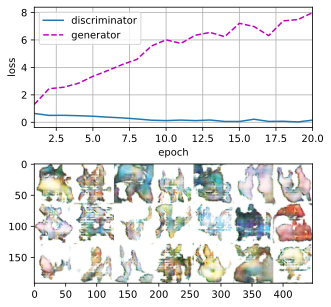

In [19]:
latent_dim, lr, num_epochs = 100, 0.005, 20
train(net_D, net_G, data_iter, num_epochs, lr, latent_dim)


### Custom dataset

#### GAN generated images

In [ ]:
!mkdir GAN
%cd GAN

In [12]:
# Check for GPU availability
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

for i in range(10000):
  Z = torch.normal(0, 1, size=(1, latent_dim, 1, 1), device=device)
  # Normalize the synthetic data to N(0, 1)
  fake_x = net_G(Z) / 2 + 0.5
  fake_img = fake_x.cpu().detach()[0].squeeze()

  # Save the image tensor as a file
  save_image(fake_img, f'fake_({i}).png')

In [14]:
%cd ..
!ls

sample_data


#### Real images

In [16]:
!mkdir REAL

In [17]:
img_num = 0
# extract real images from the pokemon dataset
for X, _ in data_iter:
    for img in X:
       # Save the image tensor as a file
        save_image(img, f'./REAL/real_({img_num}).png')
        img_num += 1

### FID score

In [18]:
pip install clean-fid

In [20]:
from cleanfid import fid
vanilla_score = fid.compute_fid("./REAL", "./GAN")
print(vanilla_score)

compute FID between two folders
Found 40597 images in the folder ./REAL


FID REAL : 100%|██████████| 1269/1269 [04:03<00:00,  5.21it/s]


Found 10000 images in the folder ./GAN


FID GAN : 100%|██████████| 313/313 [00:55<00:00,  5.61it/s]


205.05482464354887


## Train Discriminator

#### Custum datasets

In [21]:
class CustomImageDataset(Dataset):
    def __init__(self, dataframe, img_dir, transform=None, target_transform=None):
      self.img_labels = dataframe
      self.img_dir = img_dir
      self.transform = transform
      self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = read_image(img_path)
        label = self.img_labels.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

In [22]:
def showNineImgs(data):
  # Check if data was loaded without any problems
  labels_map = {
      0: "fake",
      1: "real",
  }
  figure = plt.figure(figsize=(4, 4))
  cols, rows = 3, 3
  for i in range(1, cols * rows + 1):
      sample_idx = torch.randint(len(data), size=(1,)).item()
      img, label = data[sample_idx]
      img = img/2+0.5
      figure.add_subplot(rows, cols, i)
      plt.title(labels_map[label])
      plt.axis("off")
      plt.imshow(img.permute(1, 2, 0).squeeze(), cmap="gray")
  plt.show()

In [23]:
image = read_image("./GAN/GAN/fake_(0).png")

In [24]:
image.shape

torch.Size([3, 64, 64])

In [25]:
img2 = read_image("./REAL/real_(0).png")
img2.shape

torch.Size([3, 64, 64])

In [26]:
TRAIN_ANNO_PATH = "train_labels.csv"

train_paths_fake = list(glob('./GAN/GAN/*.png'))
print(len(train_paths_fake))

df_train_fake = pd.DataFrame(train_paths_fake)
df_train_fake.columns = ['path']
df_train_fake['label'] = 0
df_train_fake.head()

train_paths_real = list(glob('./REAL/*.png'))
print(len(train_paths_real))

df_train_real = pd.DataFrame(train_paths_real)
df_train_real.columns = ['path']
df_train_real['label'] = 1
df_train_real.head()

df_train = pd.concat((df_train_fake, df_train_real), axis = 0 )
print(df_train.shape)

df_train.to_csv(TRAIN_ANNO_PATH, index=False)

10000
40597
(50597, 2)


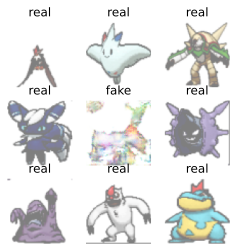

In [27]:
dataset = CustomImageDataset(pd.read_csv(TRAIN_ANNO_PATH), "", transform=lambda img: img.type(torch.FloatTensor) / 255)
showNineImgs(dataset)

In [28]:
# Calculate the sizes of the training, validation, and test sets
train_size = int(0.6 * len(dataset))
val_size = int(0.2 * len(dataset))
test_size = len(dataset) - train_size - val_size

# Split the dataset into training, validation, and test sets
train_set, val_set, test_set = torch.utils.data.random_split(dataset, [train_size, val_size, test_size])

# Create DataLoaders for the training, validation, and test sets
train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
val_loader = DataLoader(val_set, batch_size=32, shuffle=False)
test_loader = DataLoader(test_set, batch_size=32, shuffle=False)

### Pretrain previous discriminator

#### train

In [45]:
net_D = get_fresh_net_D()

In [30]:
lr = 0.00001
num_epochs = 10

for w in net_D.parameters():
        nn.init.normal_(w, 0, 0.02)
net_D = net_D.to(device)
net_D.train()
losses = []
val_losses = []
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(net_D.parameters(), lr=lr)

# Assuming train_loader provides batches of input data and corresponding labels
for epoch in range(num_epochs):
    epoch_loss = 0.0  # Initialize epoch loss
    for i, data in enumerate(train_loader, start=0):
        inputs, labels = data  # Get inputs and corresponding labels

        # Move inputs and labels to the GPU
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()  # Zero the gradients
        outputs = net_D(inputs)  # Forward pass
        loss = criterion(outputs.squeeze(), labels.float())  # Calculate loss
        loss.backward()  # Backpropagation
        optimizer.step()  # Update weights based on gradients

        # Accumulate epoch loss
        epoch_loss += loss.item()

        # Optionally, print the loss
        if i % 200 == 0:
          print(f"Epoch [{epoch+1}/{num_epochs}], Batch [{i+1}/{len(train_loader)}], Loss: {loss.item():.4f}")

  # Calculate average epoch loss and store it
    avg_epoch_loss = epoch_loss / len(train_loader)
    losses.append(avg_epoch_loss)

    if epoch % 10 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Average Epoch Loss: {avg_epoch_loss:.4f}")

Epoch [1/10], Batch [1/949], Loss: 0.6825
Epoch [1/10], Batch [201/949], Loss: 0.4273
Epoch [1/10], Batch [401/949], Loss: 0.3129
Epoch [1/10], Batch [601/949], Loss: 0.2030
Epoch [1/10], Batch [801/949], Loss: 0.1218
Epoch [1/10], Average Epoch Loss: 0.3028
Epoch [2/10], Batch [1/949], Loss: 0.0856
Epoch [2/10], Batch [201/949], Loss: 0.0828
Epoch [2/10], Batch [401/949], Loss: 0.0482
Epoch [2/10], Batch [601/949], Loss: 0.0344
Epoch [2/10], Batch [801/949], Loss: 0.0268
Epoch [3/10], Batch [1/949], Loss: 0.0203
Epoch [3/10], Batch [201/949], Loss: 0.0159
Epoch [3/10], Batch [401/949], Loss: 0.0160
Epoch [3/10], Batch [601/949], Loss: 0.0111
Epoch [3/10], Batch [801/949], Loss: 0.0078
Epoch [4/10], Batch [1/949], Loss: 0.0072
Epoch [4/10], Batch [201/949], Loss: 0.0071
Epoch [4/10], Batch [401/949], Loss: 0.0054
Epoch [4/10], Batch [601/949], Loss: 0.0049
Epoch [4/10], Batch [801/949], Loss: 0.0037
Epoch [5/10], Batch [1/949], Loss: 0.0033
Epoch [5/10], Batch [201/949], Loss: 0.0026
E

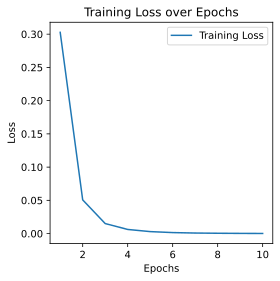

In [31]:
# Plotting the loss
plt.plot(range(1, num_epochs + 1), losses, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()
plt.show()


#### test

In [32]:
torch.save(net_D.state_dict(), 'net_D_pretrained.pth')

In [33]:
# Load the trained model
#model = SimpleCNN()
#model.load_state_dict(torch.load('./drive/MyDrive/Github/COSE474_Term_Project/model_weights.pth'))
net_D.eval()

# Evaluate the model
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in test_loader:

        # Move inputs and labels to the GPU
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = net_D(inputs)
        # Compute predictions
        predictions = torch.round(torch.sigmoid(outputs)).squeeze().cpu().detach().numpy()
        true_labels = labels.cpu().numpy()

        total += labels.size(0)
        correct += (predictions == true_labels).sum().item()

accuracy = correct / total
print(f'Accuracy on the test dataset: {accuracy}')

Accuracy on the test dataset: 1.0


## Train generator model, initialize  discriminator with pretrained weights

In [34]:
new_net_D = get_fresh_net_D()
new_net_D.train()

Sequential(
  (0): D_block(
    (conv2d): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (batch_norm): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (activation): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (1): D_block(
    (conv2d): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (batch_norm): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (activation): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (2): D_block(
    (conv2d): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (batch_norm): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (activation): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (3): D_block(
    (conv2d): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (batch_norm): BatchNorm2d(512, eps=1e-05, momentum=0.1

loss_D 0.100, loss_G 7.586, 657.9 examples/sec on cuda:0


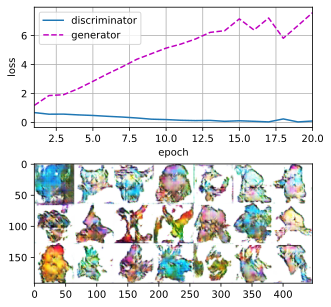

In [35]:
latent_dim, lr, num_epochs = 100, 0.005, 20
train(new_net_D, net_G, data_iter, num_epochs, lr, latent_dim, pretrained_D='net_D_pretrained.pth')

#### FID Score

In [36]:
!mkdir GEN


In [37]:
%cd ./GEN

for i in range(10000):
  Z = torch.normal(0, 1, size=(1, latent_dim, 1, 1), device=device)
  # Normalize the synthetic data to N(0, 1)
  fake_educated_x = net_G(Z) / 2 + 0.5
  fake_educated_img = fake_educated_x.cpu().detach()[0].squeeze()

  # Save the image tensor as a file
  save_image(fake_educated_img, f't_({i}).png')

/content/GEN


In [38]:
%cd ..

/content


In [42]:
from cleanfid import fid
gen_score = fid.compute_fid("./REAL", "./GEN")

compute FID between two folders
Found 40597 images in the folder ./REAL


FID REAL : 100%|██████████| 1269/1269 [04:05<00:00,  5.17it/s]


Found 10000 images in the folder ./GEN


FID GEN : 100%|██████████| 313/313 [01:01<00:00,  5.08it/s]


In [43]:
gen_score

198.67922565456968

## Train generator model, **freeze** discriminator with pretrained weights

In [34]:
frozen_D = get_fresh_net_D()

Sequential(
  (0): D_block(
    (conv2d): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (batch_norm): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (activation): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (1): D_block(
    (conv2d): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (batch_norm): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (activation): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (2): D_block(
    (conv2d): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (batch_norm): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (activation): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (3): D_block(
    (conv2d): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (batch_norm): BatchNorm2d(512, eps=1e-05, momentum=0.1

loss_D 1.042, loss_G 0.293, 631.7 examples/sec on cuda:0


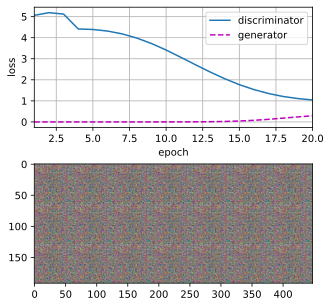

In [35]:
# strictly frozen discriminator with learning rate 0.000001
latent_dim, lr, num_epochs = 100, 0.005, 20
train(frozen_D, net_G, data_iter, num_epochs, lr, latent_dim, pretrained_D='net_D_pretrained.pth', freeze_D=True)

#### FID Score

In [36]:
!mkdir frozen_GEN
%cd ./frozen_GEN

In [39]:
for i in range(10000):
  Z = torch.normal(0, 1, size=(1, latent_dim, 1, 1), device=device)
  # Normalize the synthetic data to N(0, 1)
  fake_educated_x = net_G(Z) / 2 + 0.5
  fake_educated_img = fake_educated_x.cpu().detach()[0].squeeze()

  # Save the image tensor as a file
  save_image(fake_educated_img, f'frozen_({i}).png')

In [40]:
%cd ..

/content


In [41]:
from cleanfid import fid
frozen_score = fid.compute_fid("./REAL", "./frozen_GEN")
print(frozen_score)

compute FID between two folders
Found 40597 images in the folder ./REAL


FID REAL : 100%|██████████| 1269/1269 [04:24<00:00,  4.81it/s]


Found 10000 images in the folder ./frozen_GEN


FID frozen_GEN : 100%|██████████| 313/313 [01:04<00:00,  4.87it/s]


502.9096353258123


## Teach pretrained generator

In [49]:
G = get_fresh_net_G()
D = get_fresh_net_D()

loss_D 0.021, loss_G 7.770, 635.8 examples/sec on cuda:0


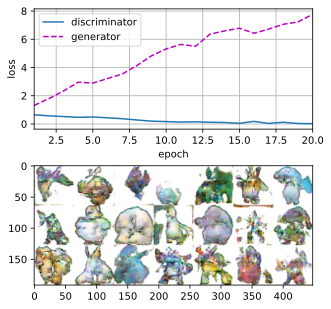

In [50]:
latent_dim, lr, num_epochs = 100, 0.005, 20
train(D, G, data_iter, num_epochs, lr, latent_dim)

In [51]:
torch.save(G.state_dict(), 'net_G_pretrained.pth')

loss_D 0.702, loss_G 0.686, 636.1 examples/sec on cuda:0


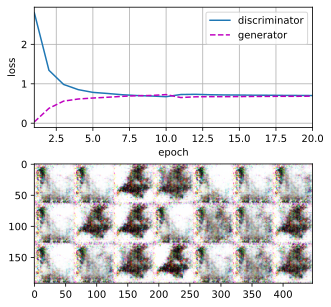

In [54]:
# light-frozen discriminator with learning rate 0.00001
train(D, G, data_iter, num_epochs, lr, latent_dim, pretrained_D='net_D_pretrained.pth', freeze_D=True, pretrained_G='net_G_pretrained.pth')

In [65]:
!mkdir both_trained_GEN
%cd ./both_trained_GEN

mkdir: cannot create directory ‘both_trained_GEN’: File exists
/content/both_trained_GEN


In [66]:
for i in range(10000):
    Z = torch.normal(0, 1, size=(1, latent_dim, 1, 1), device=device)
    # Normalize the synthetic data to N(0, 1)
    fake_educated_x = net_G(Z) / 2 + 0.5
    fake_educated_img = fake_educated_x.cpu().detach()[0].squeeze()

    # Save the image tensor as a file
    save_image(fake_educated_img, f'both_trained_GEN_({i}).png')

In [67]:
%cd ..

/content


In [68]:
fid_score = fid.compute_fid("./REAL", "./both_trained_GEN")
print(fid_score)

compute FID between two folders
Found 40597 images in the folder ./REAL


FID REAL : 100%|██████████| 1269/1269 [03:52<00:00,  5.45it/s]


Found 10000 images in the folder ./both_trained_GEN


FID both_trained_GEN : 100%|██████████| 313/313 [01:01<00:00,  5.10it/s]


502.9631179407995
